# Applied ML : Assignment 5

## Transfer Learning : Duck vs Chicken Classification

## Rohit Roy | MDS202340

### Preparing the Data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random
from tqdm import tqdm

In [2]:
# Unzip dataset
zip_path = "data.zip"
extract_dir = "data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Define dataset path
train_dir = os.path.join(extract_dir, "data/chicken-images/data/train")
test_dir = os.path.join(extract_dir, "data/chicken-images/data/test")
val_dir = os.path.join(extract_dir, "data/chicken-images/data/val")

duck_train_dir = os.path.join(extract_dir, "data/duck-images/data/train")
duck_test_dir = os.path.join(extract_dir, "data/duck-images/data/test")
duck_val_dir = os.path.join(extract_dir, "data/duck-images/data/val")

# Merge paths for ImageFolder compatibility
merged_train_dir = "merged_data/train"
merged_test_dir = "merged_data/test"
merged_val_dir = "merged_data/val"

os.makedirs(merged_train_dir, exist_ok=True)
os.makedirs(merged_test_dir, exist_ok=True)
os.makedirs(merged_val_dir, exist_ok=True)

!cp -r {train_dir} {merged_train_dir}/chicken
!cp -r {test_dir} {merged_test_dir}/chicken
!cp -r {val_dir} {merged_val_dir}/chicken

!cp -r {duck_train_dir} {merged_train_dir}/duck
!cp -r {duck_test_dir} {merged_test_dir}/duck
!cp -r {duck_val_dir} {merged_val_dir}/duck

### Normalizing images for fitting in the model

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = ImageFolder(root=merged_train_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

test_dataset = ImageFolder(root=merged_test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Display sample images

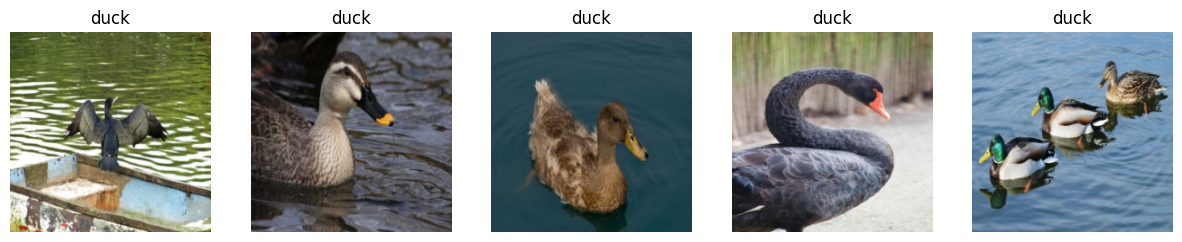

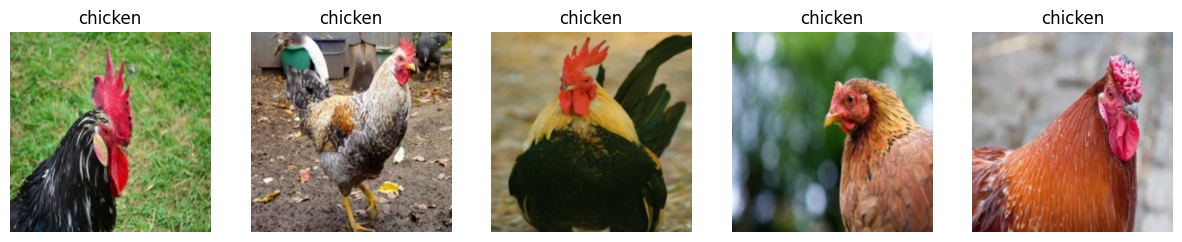

In [4]:
# Display sample images
def show_sample_images(dataset, class_name, num_images=5):
    class_idx = dataset.class_to_idx[class_name]
    class_images = [i for i in range(len(dataset)) if dataset.imgs[i][1] == class_idx]
    selected_images = random.sample(class_images, num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(selected_images):
        image, _ = dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # Convert tensor to numpy format
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        image = np.clip(image, 0, 1)  # Clip values to valid range
        axes[i].imshow(image)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

show_sample_images(dataset, "duck", 5)
show_sample_images(dataset, "chicken", 5)

### Loading pre-trained model

In [5]:
# Load pre-trained model
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze all existing layers

# Modify the model by adding new layers
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)  # 2 classes: duck, chicken
)

# Only train the newly added layers
for param in model.fc.parameters():
    param.requires_grad = True

# Print model summary
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


Trainable parameters: 131842
Non-trainable parameters: 11176512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

### Fine-tuning the model

In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1: 100%|██████████| 57/57 [00:05<00:00, 11.18it/s, loss=0.284]


Epoch 1, Loss: 0.2845


Epoch 2: 100%|██████████| 57/57 [00:04<00:00, 13.47it/s, loss=0.179]


Epoch 2, Loss: 0.1789


Epoch 3: 100%|██████████| 57/57 [00:03<00:00, 15.59it/s, loss=0.14]


Epoch 3, Loss: 0.1397


Epoch 4: 100%|██████████| 57/57 [00:03<00:00, 15.33it/s, loss=0.147]


Epoch 4, Loss: 0.1467


Epoch 5: 100%|██████████| 57/57 [00:04<00:00, 13.42it/s, loss=0.131]


Epoch 5, Loss: 0.1312


Epoch 6: 100%|██████████| 57/57 [00:03<00:00, 15.51it/s, loss=0.194]


Epoch 6, Loss: 0.1938


Epoch 7: 100%|██████████| 57/57 [00:03<00:00, 15.54it/s, loss=0.241]


Epoch 7, Loss: 0.2408


Epoch 8: 100%|██████████| 57/57 [00:04<00:00, 13.85it/s, loss=0.149]


Epoch 8, Loss: 0.1494


Epoch 9: 100%|██████████| 57/57 [00:03<00:00, 14.30it/s, loss=0.105]


Epoch 9, Loss: 0.1052


Epoch 10: 100%|██████████| 57/57 [00:04<00:00, 12.89it/s, loss=0.12]


Epoch 10, Loss: 0.1202


Epoch 11: 100%|██████████| 57/57 [00:04<00:00, 13.65it/s, loss=0.088]


Epoch 11, Loss: 0.0880


Epoch 12: 100%|██████████| 57/57 [00:03<00:00, 15.59it/s, loss=0.119]


Epoch 12, Loss: 0.1191


Epoch 13: 100%|██████████| 57/57 [00:03<00:00, 15.72it/s, loss=0.0746]


Epoch 13, Loss: 0.0746


Epoch 14: 100%|██████████| 57/57 [00:04<00:00, 12.64it/s, loss=0.13]


Epoch 14, Loss: 0.1303


Epoch 15: 100%|██████████| 57/57 [00:04<00:00, 12.96it/s, loss=0.109]

Epoch 15, Loss: 0.1090


### Classification Report

In [7]:
# Evaluation
model.eval()
y_true = []
y_pred = []
sample_images = []
sample_labels = []
sample_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Collect sample images for display
        sample_images.extend(images.cpu())
        sample_labels.extend(labels.cpu().numpy())
        sample_preds.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

     chicken       0.96      0.92      0.94       172
        duck       0.96      0.98      0.97       310

    accuracy                           0.96       482
   macro avg       0.96      0.95      0.95       482
weighted avg       0.96      0.96      0.96       482



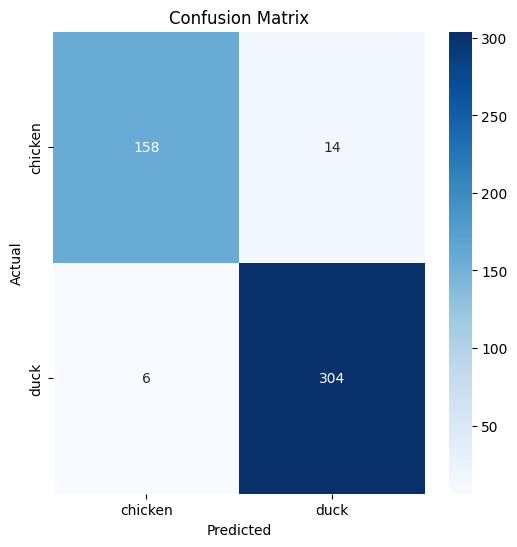

In [8]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Displaying sample predictions

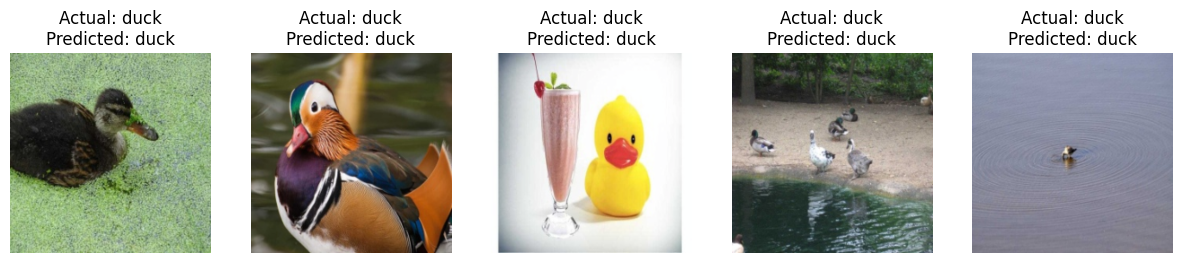

In [9]:
# Display random sample predictions
num_samples = 5
random_indices = random.sample(range(len(sample_images)), num_samples)
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image = sample_images[idx].permute(1, 2, 0).numpy()
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    image = np.clip(image, 0, 1)
    actual_label = dataset.classes[sample_labels[idx]]
    predicted_label = dataset.classes[sample_preds[idx]]

    axes[i].imshow(image)
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    axes[i].axis("off")
plt.show()